In [105]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd.functional import jacobian


torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM=2

TRAIN_SLOPE = 1
EVAL_SLOPE = 1
X_LOWER_BOUND = -30
X_UPPER_BOUND = 30

In [2]:
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1][:100]
    Xneg = X[Y == -1][:100]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], XposOpt[:, 2], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], XnegOpt[:, 2], marker='_', color='red')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_strategic[0] * xx - w_strategic[1] * yy - b_strategic) * 1. /w_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], marker='_', color='red')

    range_arr = torch.arange(-0.5, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_strategic[0] * xx - b_strategic) * 1. /w_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='red')

    plt.show()
    
def visualize_strategic_data(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
    else:
        visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# Utils

In [3]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [45]:
def gen_custom_normal_data(N, x_dim, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, x_dim))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, x_dim))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def gen_custom_sin_data(N, shuff=True):
    
    def func(x):
#         return 0.25*x**3
#         return (x+1)**3-3*(x+1)**2+2
        return -(x**2)
    
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    
    posX = torch.linspace(-5, 0, pos_samples_num)
    posX = torch.stack([posX, func(posX)])
    posX = torch.transpose(posX, 1, 0)
    
    negX = torch.linspace(0, 5, neg_samples_num)
    negX = torch.stack([negX, func(negX)])
    negX = torch.transpose(negX, 1, 0)
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)
    if shuff:
        X, Y = shuffle(X, Y)
    else:
        Y = Y[:, 0]
    return X, Y

# CCP classes

In [46]:
class CCP:
    def __init__(self, x_dim, h_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)
        

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, B_SPAN, slope):
        """
        tensor to tensor
        """
        X = X.numpy()
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])
    
    
class CCP_MANIFOLD:
    def __init__(self, x_dim, h_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.v = cp.Variable(h_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.B_span = cp.Parameter((x_dim, h_dim))
        self.slope = cp.Parameter(1)
        

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND,
                      self.B_span@self.v == self.x-self.r]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r, B_span):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        self.B_span.value = B_span
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, B_SPAN, slope):
        """
        tensor to tensor
        """
        X = X.numpy()
        w = w.detach().numpy()
        b = b.detach().numpy()
        B_SPAN = B_SPAN.numpy()
        slope = np.full(1, slope)
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x, B_span)) for x, B_span in zip(X, B_SPAN)])

In [47]:
class DELTA():
    
    def __init__(self, x_dim, h_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
        
    def optimize_X(self, X, w, b, F_DER, B_SPAN):
        return self.layer(X, w, b, F_DER)[0]
    
class DELTA_MANIFOLD():
    
    def __init__(self, x_dim, h_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.v = cp.Variable(h_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.B_span = cp.Parameter((x_dim, h_dim), value = np.random.randn(x_dim, h_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND,
                      self.B_span@self.v == self.x-self.r]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der, self.B_span],
                                variables=[self.x, self.v])
        
        
    def optimize_X(self, X, w, b, F_DER, B_SPAN):
        return self.layer(X, w, b, F_DER, B_SPAN)[0]

# Gain & Cost functions

In [109]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r, x_dim):
    return cp.sum_squares(x-r)/70

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "score": score}

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# CAE

In [49]:
class CAE(nn.Module):
    def __init__(self, x_dim, h_dim, h2_dim, lamb=0):
        torch.manual_seed(0)
        np.random.seed(0)
        super(CAE, self).__init__()
        
        self.lamb = lamb
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.h2_dim = h2_dim
        self.fc1 = nn.Linear(x_dim, h2_dim, bias = True) # Encoder
#         self.fc2 = nn.Linear(h2_dim, h2_dim, bias = True)
        self.fc3 = nn.Linear(h2_dim, h_dim, bias = True)
        self.fc4 = nn.Linear(h_dim, h2_dim, bias = True)
        self.fc5 = nn.Linear(h2_dim, h2_dim, bias = True)
#         self.fc6 = nn.Linear(h2_dim, h2_dim, bias = True)
        self.fc7 = nn.Linear(h2_dim, x_dim, bias = True)

        
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x):
        o1 = self.sigmoid(self.fc1(x))
#         o2 = self.sigmoid(self.fc2(o1))
        o3 = self.sigmoid(self.fc3(o1))
        return o3
    
    def decoder(self, z):
        o1 = self.sigmoid(self.fc4(z))
        o2 = self.sigmoid(self.fc5(o1))
#         o3 = self.sigmoid(self.fc6(o1))
        return self.fc7(o2)

    def forward(self, x):
            h1 = self.encoder(x)
            h2 = self.decoder(h1)
            return h1, h2
        
    def save_model(self, path, comment=None):
        if comment is not None:
            path += "/" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
        
    def get_spans(self, X):
        def func(x):
            return self.forward(x)[0]
        
#         eps = 0.01
        B_SPANS = []
#         All_S = []
        for x in X:
            J = jacobian(func, x)
            U, S, _ = torch.svd(J.T)
#             All_S.append(S)
            B_span = U
#             B_span = U[:, S>eps]
#             if B_span.size()[1] < self.h_dim:
#                 pad = torch.zeros((x_dim, self.h_dim-B_span.size()[1]))
#                 B_span = torch.cat((B_span, pad), 1)
            B_SPANS.append(B_span)
#         All_S = torch.stack(All_S)
#         print("mean of S:", torch.mean(All_S, 0))
#         print("std of S:", torch.std(All_S, 0))
        return torch.stack(B_SPANS)
    
    def contractive_loss(self, x):
        def func(x):
            return self.encoder(x)
        J = jacobian(func, x, create_graph=True)
        c_loss = torch.norm(J, 2)**2

#         W = self.state_dict()['fc1.weight']
#         dh = h * (1 - h) # Hadamard product produces size N_batch x N_hidden
#         # Sum through the input dimension to improve efficiency, as suggested in #1
#         w_sum = torch.sum(Variable(W)**2, dim=1)
#         # unsqueeze to avoid issues with torch.mv
#         w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
#         c_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
# #         print("c_loss: ", c_loss)
        return c_loss
    
    def reconstruction_loss(self, x, x_recons):
        mse_loss = nn.MSELoss(size_average = True)
        r_loss = mse_loss(x_recons, x)
#         print("r_loss: ", r_loss)
        return r_loss
        
    def loss(self, x, x_recons, h):
        """Compute the Contractive AutoEncoder Loss
        Evalutes the CAE loss, which is composed as the summation of a Mean
        Squared Error and the weighted l2-norm of the Jacobian of the hidden
        units with respect to the inputs.
        See reference below for an in-depth discussion:
          #1: http://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder
        Args:
            `W` (FloatTensor): (N_hidden x N), where N_hidden and N are the
              dimensions of the hidden units and input respectively.
            `x` (Variable): the input to the network, with dims (N_batch x N)
            recons_x (Variable): the reconstruction of the input, with dims
              N_batch x N.
            `h` (Variable): the hidden units of the network, with dims
              batch_size x N_hidden
            `lam` (float): the weight given to the jacobian regulariser term
        Returns:
            Variable: the (scalar) CAE loss
        """
        r_loss = self.reconstruction_loss(x, x_recons)
        c_loss = self.contractive_loss(x)
        return r_loss, c_loss

    def fit(self, path, X, Xval, lamb2, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, comment=None):
        train_dset = TensorDataset(X, torch.ones(len(X)))
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)
        
        best_val_loss = 100
        
        for epoch in range(epochs):
            total_r_loss = 0
            total_c_loss = 0
            train_loss = 0
            self.train()
#             W1 = self.state_dict()['fc1.weight']
#             W2 = self.state_dict()['fc3.weight']
            for idx, (Xbatch, _) in enumerate(train_loader):
                Xbatch = Variable(Xbatch)
                opt.zero_grad()
                
                hidden_representation, recons_x = self.forward(Xbatch)
                r_loss, c_loss = self.loss(Xbatch, recons_x, hidden_representation)
                l = r_loss + self.lamb*c_loss #+ lamb2*(torch.norm(W1, 2)**2 + torch.norm(W2, 2)**2)
                l.backward()
                train_loss += l.item()
                total_r_loss += r_loss.item()
                total_c_loss += c_loss.item()
                opt.step()

            
            hidden_representation, recons_x = self.forward(Xval)
            r_loss, c_loss = self.loss(Xval, recons_x, hidden_representation)
            l = r_loss + self.lamb*c_loss#+ lamb2*(torch.norm(W1, 2)**2 + torch.norm(W2, 2)**2)
            if l.item() < best_val_loss:
                self.save_model(path, comment)
                best_val_loss = l.item()
                print("model saved!")
                
            if verbose:
                print('====> Epoch: {} Average loss: {:.4f}'.format(
                     epoch, l.item()), " reconstruction loss: ", r_loss.item(), "contractive_loss: ", c_loss.item())
            
                
#                 h, _ = self.forward(Xbatch)
#                 W = self.state_dict()['fc1.weight']
#                 dh = h * (1 - h)
#                 J = jacobian(lambda x: self.encoder(x), Xbatch)
#                 print(J, dh*W)


# Model

In [50]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, strategic=False, manifold=False):
        torch.manual_seed(0)
        np.random.seed(0)
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.h_dim = cae.h_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.strategic = strategic
        self.manifold = manifold
        if self.manifold:
            self.ccp_train = CCP_MANIFOLD(self.x_dim, self.h_dim, funcs)
            self.delta = DELTA_MANIFOLD(self.x_dim, self.h_dim, funcs)
        else:
            self.ccp_train = CCP(self.x_dim, self.h_dim, funcs)
            self.delta = DELTA(self.x_dim, self.h_dim, funcs)
        
        self.ccp_test = CCP_MANIFOLD(self.x_dim, self.h_dim, funcs)

    def forward(self, X, B_SPANS, evaluation=False):
        if self.strategic:            
            if evaluation:
                XT = self.ccp_train.optimize_X(X, self.w, self.b, B_SPANS, self.eval_slope)
                X_opt = XT
            else:
                XT = self.ccp_train.optimize_X(X, self.w, self.b, B_SPANS, self.train_slope)
                F_DER = self.get_f_ders(XT, self.train_slope)
                X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, B_SPANS) # Xopt should be equal to XT but we do it again for the gradients
                
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        return output
    
    def optimize_X(self, X, B_SPANS):
        return self.ccp_test.optimize_X(X, self.w, self.b, B_SPANS, self.eval_slope)
    
    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def calc_accuracy(self, Y, Y_pred):
        Y_pred = torch.sign(Y_pred)
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def evaluate(self, X, B_SPANS, Y):      
        return self.calc_accuracy(Y, self.forward(X, B_SPANS, evaluation=True))
    
    def loss(self, Y, Y_pred):
        return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
    
    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, path, X, B_SPANS, Y, Xval, B_SPANSval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, comment=None):
        train_dset = TensorDataset(X, B_SPANS, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        
        best_val_error = 1
        consecutive_no_improvement = 0

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, B_SPANSbatch, Ybatch in train_loader:
                opt.zero_grad()
                Ybatch_pred = self.forward(Xbatch, B_SPANSbatch)
                l = self.loss(Ybatch, Ybatch_pred)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    e = self.calc_accuracy(Ybatch, Ybatch_pred)
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                Yval_pred = self.forward(Xval, B_SPANSval, evaluation=True)
                val_loss = self.loss(Yval, Yval_pred).item()
                val_losses.append(val_loss)
                val_error = 1-self.calc_accuracy(Yval, Yval_pred)
                val_errors.append(val_error)
                if val_error < best_val_error:
                    consecutive_no_improvement = 0
                    best_val_error = val_error
                    info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                    time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error)
                    self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                    print("model saved!")
                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break
                
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

# Data generation

torch.Size([180, 2]) torch.Size([180])


<IPython.core.display.Javascript object>


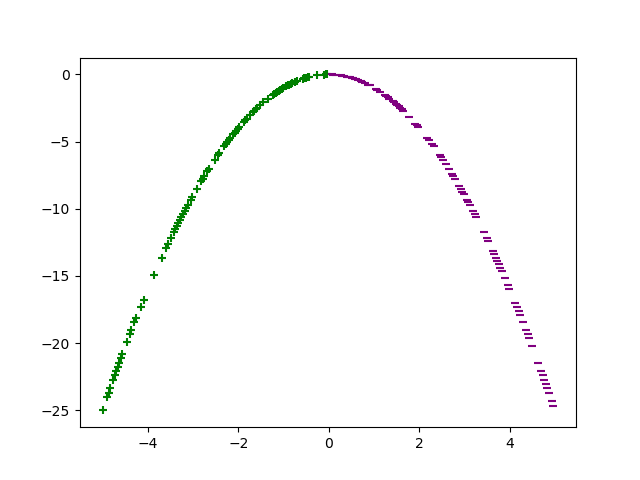

torch.Size([180, 2]) torch.Size([60, 2])
percent of positive samples: 49.44444444444444%


In [54]:
N = 300
x_dim = 2
h_dim = 1
h_dim2 = 5
X, Y = gen_custom_sin_data(N)
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)

print(X.size(), Y.size())
visualize_data(X, Y)
print(X.size(), Xval.size())
print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))


In [56]:
path = "C:/Users/sagil/Desktop/nir_project/models/manifold/CAE"
lamb2 = 0.01
cae = CAE(x_dim, h_dim, h_dim2, 0.0001)
cae.fit(path, X, Xval, lamb2, opt=torch.optim.Adam, opt_kwargs={"lr": (5e-2)}, batch_size=24, epochs=2000, verbose=True, comment='exp1')
# B_SPANS =torch.stack([torch.tensor([[0],[1]], dtype=torch.float64) for i in range(len(X))])
# B_SPANSval =torch.stack([torch.tensor([[0],[1]], dtype=torch.float64) for i in range(len(Xval))])
# B_SPANStest =torch.stack([torch.tensor([[0],[1]], dtype=torch.float64) for i in range(len(Xtest))])

model saved!
====> Epoch: 0 Average loss: 67.0099  reconstruction loss:  67.00986307035559 contractive_loss:  0.015148216166793451
model saved!
====> Epoch: 1 Average loss: 55.3215  reconstruction loss:  55.32148341547058 contractive_loss:  0.01480299402884573
model saved!
====> Epoch: 2 Average loss: 44.0618  reconstruction loss:  44.061836571542976 contractive_loss:  0.0025385916894494504
model saved!
====> Epoch: 3 Average loss: 36.8753  reconstruction loss:  36.875255943009456 contractive_loss:  0.0012528677292210555
model saved!
====> Epoch: 4 Average loss: 34.7976  reconstruction loss:  34.79763650269472 contractive_loss:  0.0007963016878656137
model saved!
====> Epoch: 5 Average loss: 34.5090  reconstruction loss:  34.50900747756144 contractive_loss:  0.0005007280340292264
====> Epoch: 6 Average loss: 34.7226  reconstruction loss:  34.722561712667726 contractive_loss:  0.000328870981020331
====> Epoch: 7 Average loss: 35.1378  reconstruction loss:  35.13780435405037 contractive_

====> Epoch: 68 Average loss: 6.4106  reconstruction loss:  6.410568360275988 contractive_loss:  0.29715748378378193
====> Epoch: 69 Average loss: 7.3255  reconstruction loss:  7.325460606889347 contractive_loss:  0.23051142899445856
====> Epoch: 70 Average loss: 6.7765  reconstruction loss:  6.776419275560446 contractive_loss:  0.3603977096750054
====> Epoch: 71 Average loss: 6.7605  reconstruction loss:  6.760466714333437 contractive_loss:  0.3067299330023384
====> Epoch: 72 Average loss: 6.2981  reconstruction loss:  6.298034454024727 contractive_loss:  0.33768221231001827
model saved!
====> Epoch: 73 Average loss: 6.0654  reconstruction loss:  6.06535881336083 contractive_loss:  0.337180631255334
====> Epoch: 74 Average loss: 6.1328  reconstruction loss:  6.132751173046524 contractive_loss:  0.3052731038402564
====> Epoch: 75 Average loss: 6.0804  reconstruction loss:  6.080387456618241 contractive_loss:  0.3172334880340959
model saved!
====> Epoch: 76 Average loss: 5.9444  reconst

====> Epoch: 137 Average loss: 5.0962  reconstruction loss:  5.096131716405579 contractive_loss:  0.3372863536460341
====> Epoch: 138 Average loss: 5.0679  reconstruction loss:  5.067907383406132 contractive_loss:  0.3395407087053001
====> Epoch: 139 Average loss: 5.1164  reconstruction loss:  5.116400932383044 contractive_loss:  0.33993095667532996
====> Epoch: 140 Average loss: 5.0644  reconstruction loss:  5.06438260800135 contractive_loss:  0.34978568050117287
====> Epoch: 141 Average loss: 5.0800  reconstruction loss:  5.080014558403388 contractive_loss:  0.3384380144992571
====> Epoch: 142 Average loss: 5.0683  reconstruction loss:  5.0682447210141515 contractive_loss:  0.35878464013045247
====> Epoch: 143 Average loss: 5.0599  reconstruction loss:  5.059853426997305 contractive_loss:  0.3536399429926657
====> Epoch: 144 Average loss: 5.0621  reconstruction loss:  5.0620901193673395 contractive_loss:  0.3785157721765789
====> Epoch: 145 Average loss: 5.0306  reconstruction loss: 

====> Epoch: 207 Average loss: 4.8143  reconstruction loss:  4.814259396246958 contractive_loss:  0.6026896047721689
====> Epoch: 208 Average loss: 4.5901  reconstruction loss:  4.590070092744907 contractive_loss:  0.6697333680733295
model saved!
====> Epoch: 209 Average loss: 4.3461  reconstruction loss:  4.346058550029818 contractive_loss:  0.6767239430520816
====> Epoch: 210 Average loss: 4.5577  reconstruction loss:  4.55760011992386 contractive_loss:  0.5716523979707855
====> Epoch: 211 Average loss: 5.2395  reconstruction loss:  5.239446854317124 contractive_loss:  0.35396925308756627
====> Epoch: 212 Average loss: 4.7912  reconstruction loss:  4.79112600469336 contractive_loss:  0.5042609316511566
====> Epoch: 213 Average loss: 4.3565  reconstruction loss:  4.356473964123571 contractive_loss:  0.4538437971101239
====> Epoch: 214 Average loss: 4.7001  reconstruction loss:  4.700049019818076 contractive_loss:  0.5837172224005422
====> Epoch: 215 Average loss: 4.5529  reconstructio

====> Epoch: 277 Average loss: 4.7480  reconstruction loss:  4.747946147502758 contractive_loss:  0.30794353629326304
model saved!
====> Epoch: 278 Average loss: 3.9517  reconstruction loss:  3.95159099591529 contractive_loss:  0.7829414641319383
====> Epoch: 279 Average loss: 4.0364  reconstruction loss:  4.036289852971172 contractive_loss:  0.8746555680070116
====> Epoch: 280 Average loss: 4.2027  reconstruction loss:  4.2026594550934995 contractive_loss:  0.8190640839261584
====> Epoch: 281 Average loss: 4.2973  reconstruction loss:  4.297255991889589 contractive_loss:  0.7689106931745966
====> Epoch: 282 Average loss: 4.1970  reconstruction loss:  4.196886333028124 contractive_loss:  0.8077642195798848
====> Epoch: 283 Average loss: 4.2571  reconstruction loss:  4.257067861153492 contractive_loss:  0.7991006162550942
====> Epoch: 284 Average loss: 4.0582  reconstruction loss:  4.058130007556048 contractive_loss:  0.8118196720804712
====> Epoch: 285 Average loss: 4.1125  reconstruct

====> Epoch: 347 Average loss: 4.0442  reconstruction loss:  4.044110873572843 contractive_loss:  1.0290237835881229
====> Epoch: 348 Average loss: 3.8160  reconstruction loss:  3.81592458204477 contractive_loss:  1.0161519657230742
====> Epoch: 349 Average loss: 4.2261  reconstruction loss:  4.225986483814052 contractive_loss:  0.8559960350609884
====> Epoch: 350 Average loss: 4.0915  reconstruction loss:  4.091433777564591 contractive_loss:  0.9840205630340465
====> Epoch: 351 Average loss: 4.0773  reconstruction loss:  4.077242819174247 contractive_loss:  1.0486377271767986
====> Epoch: 352 Average loss: 4.3750  reconstruction loss:  4.3749286083765195 contractive_loss:  1.0913192302485764
====> Epoch: 353 Average loss: 3.9383  reconstruction loss:  3.9382258681401225 contractive_loss:  1.1350956641521561
====> Epoch: 354 Average loss: 5.5353  reconstruction loss:  5.535229063677932 contractive_loss:  1.1085682997511437
====> Epoch: 355 Average loss: 4.0872  reconstruction loss:  4.

====> Epoch: 417 Average loss: 3.7411  reconstruction loss:  3.7410427663242425 contractive_loss:  0.6077894746914189
====> Epoch: 418 Average loss: 3.8024  reconstruction loss:  3.802319512587899 contractive_loss:  0.6501359764220848
====> Epoch: 419 Average loss: 3.4870  reconstruction loss:  3.4869085177924055 contractive_loss:  0.5595338448725244
====> Epoch: 420 Average loss: 3.1830  reconstruction loss:  3.182896624823533 contractive_loss:  0.7169690146601835
model saved!
====> Epoch: 421 Average loss: 2.7450  reconstruction loss:  2.7449715949761524 contractive_loss:  0.3054542107581247
====> Epoch: 422 Average loss: 3.5954  reconstruction loss:  3.595324513378054 contractive_loss:  0.9535719672631492
====> Epoch: 423 Average loss: 4.3421  reconstruction loss:  4.341941235929986 contractive_loss:  1.3431691234147418
====> Epoch: 424 Average loss: 3.9930  reconstruction loss:  3.9928969935482455 contractive_loss:  1.469657341036261
====> Epoch: 425 Average loss: 4.6696  reconstru

====> Epoch: 488 Average loss: 4.0331  reconstruction loss:  4.03292972589451 contractive_loss:  1.7499313057120456
====> Epoch: 489 Average loss: 4.0237  reconstruction loss:  4.023580628943146 contractive_loss:  1.6868991069652624
====> Epoch: 490 Average loss: 4.2614  reconstruction loss:  4.26126482134294 contractive_loss:  1.7411136539661716
====> Epoch: 491 Average loss: 3.8440  reconstruction loss:  3.8437996978185733 contractive_loss:  1.749346328786153
====> Epoch: 492 Average loss: 4.0436  reconstruction loss:  4.043458500565006 contractive_loss:  1.7866526367714848
====> Epoch: 493 Average loss: 3.7520  reconstruction loss:  3.7518460390815656 contractive_loss:  1.6889714094264738
====> Epoch: 494 Average loss: 3.5555  reconstruction loss:  3.5552843935045315 contractive_loss:  1.7398986204293152
====> Epoch: 495 Average loss: 4.0986  reconstruction loss:  4.0984106137753535 contractive_loss:  1.7658534929379035
====> Epoch: 496 Average loss: 3.8569  reconstruction loss:  3.

====> Epoch: 560 Average loss: 2.9278  reconstruction loss:  2.9276995186660657 contractive_loss:  1.4364273355408568
====> Epoch: 561 Average loss: 3.6330  reconstruction loss:  3.6329026273936242 contractive_loss:  0.9378831458312221
====> Epoch: 562 Average loss: 4.2867  reconstruction loss:  4.28654840452775 contractive_loss:  1.3412623531719798
====> Epoch: 563 Average loss: 3.1808  reconstruction loss:  3.1806351236412524 contractive_loss:  1.262593203831678
====> Epoch: 564 Average loss: 3.4871  reconstruction loss:  3.4869675189682336 contractive_loss:  1.159010120935703
====> Epoch: 565 Average loss: 3.6865  reconstruction loss:  3.686343769149025 contractive_loss:  1.3834803867712606
====> Epoch: 566 Average loss: 3.7783  reconstruction loss:  3.7781302088438764 contractive_loss:  1.3614942378481345
====> Epoch: 567 Average loss: 3.2005  reconstruction loss:  3.200371078277318 contractive_loss:  0.8335018507341195
====> Epoch: 568 Average loss: 3.6381  reconstruction loss:  3

====> Epoch: 631 Average loss: 5.9770  reconstruction loss:  5.976877915514704 contractive_loss:  1.2405215142729331
====> Epoch: 632 Average loss: 5.8463  reconstruction loss:  5.8461933495773 contractive_loss:  1.2658367410494384
====> Epoch: 633 Average loss: 5.7817  reconstruction loss:  5.78160568890531 contractive_loss:  1.2770465221497658
====> Epoch: 634 Average loss: 5.9042  reconstruction loss:  5.904047161579878 contractive_loss:  1.3116130884381323
====> Epoch: 635 Average loss: 5.9485  reconstruction loss:  5.948348510111826 contractive_loss:  1.298410038169557
====> Epoch: 636 Average loss: 5.6492  reconstruction loss:  5.649075688880955 contractive_loss:  1.3345732832355877
====> Epoch: 637 Average loss: 5.7260  reconstruction loss:  5.725834986469954 contractive_loss:  1.2778324562295515
====> Epoch: 638 Average loss: 5.5034  reconstruction loss:  5.503237980264718 contractive_loss:  1.3229161336888355
====> Epoch: 639 Average loss: 5.7064  reconstruction loss:  5.70627

====> Epoch: 703 Average loss: 6.1538  reconstruction loss:  6.153645022063281 contractive_loss:  1.7212037186240114
====> Epoch: 704 Average loss: 6.2673  reconstruction loss:  6.26729826514564 contractive_loss:  0.333395341130011
====> Epoch: 705 Average loss: 6.1504  reconstruction loss:  6.1503271695405735 contractive_loss:  0.25500000586232385
====> Epoch: 706 Average loss: 6.3203  reconstruction loss:  6.320283420950685 contractive_loss:  0.26958712507614396
====> Epoch: 707 Average loss: 6.2848  reconstruction loss:  6.284797424777735 contractive_loss:  0.24670246210117297
====> Epoch: 708 Average loss: 6.9012  reconstruction loss:  6.901129235963795 contractive_loss:  0.21539502132940339
====> Epoch: 709 Average loss: 10.0140  reconstruction loss:  10.013991226089285 contractive_loss:  0.27105835677904155
====> Epoch: 710 Average loss: 6.8030  reconstruction loss:  6.802979222236118 contractive_loss:  0.2529098565586843
====> Epoch: 711 Average loss: 7.7155  reconstruction loss

====> Epoch: 775 Average loss: 7.1160  reconstruction loss:  7.116002908979693 contractive_loss:  0.31189010482315316
====> Epoch: 776 Average loss: 6.5958  reconstruction loss:  6.595695989123592 contractive_loss:  0.5994207273414123
====> Epoch: 777 Average loss: 7.1219  reconstruction loss:  7.121632212227204 contractive_loss:  2.31990091300114
====> Epoch: 778 Average loss: 8.2140  reconstruction loss:  8.213724584049917 contractive_loss:  2.5867220940218623
====> Epoch: 779 Average loss: 9.2580  reconstruction loss:  9.257845405442357 contractive_loss:  2.03280979871172
====> Epoch: 780 Average loss: 10.0349  reconstruction loss:  10.03464733956151 contractive_loss:  2.1904937761145225
====> Epoch: 781 Average loss: 10.1744  reconstruction loss:  10.174162701982748 contractive_loss:  2.3406093968070683
====> Epoch: 782 Average loss: 9.1733  reconstruction loss:  9.173036059465666 contractive_loss:  2.5254772150438227
====> Epoch: 783 Average loss: 8.6242  reconstruction loss:  8.6

====> Epoch: 847 Average loss: 9.5498  reconstruction loss:  9.54952225119 contractive_loss:  2.8736342009509888
====> Epoch: 848 Average loss: 9.2960  reconstruction loss:  9.295755046243926 contractive_loss:  2.9157494516229647
====> Epoch: 849 Average loss: 9.3568  reconstruction loss:  9.356469465542736 contractive_loss:  2.946103403763646
====> Epoch: 850 Average loss: 9.4000  reconstruction loss:  9.399726357777954 contractive_loss:  2.956570664708078
====> Epoch: 851 Average loss: 9.2520  reconstruction loss:  9.251705103558125 contractive_loss:  2.986578649667915
====> Epoch: 852 Average loss: 9.4247  reconstruction loss:  9.42444917109705 contractive_loss:  2.9524986090632086
====> Epoch: 853 Average loss: 9.1139  reconstruction loss:  9.113562038307846 contractive_loss:  2.9689551382312365
====> Epoch: 854 Average loss: 8.9009  reconstruction loss:  8.900646940250148 contractive_loss:  3.0065544066085783
====> Epoch: 855 Average loss: 9.0880  reconstruction loss:  9.087707777

====> Epoch: 919 Average loss: 9.4150  reconstruction loss:  9.414673898800379 contractive_loss:  3.0671491101771626
====> Epoch: 920 Average loss: 8.9399  reconstruction loss:  8.939625928490324 contractive_loss:  3.187876092682811
====> Epoch: 921 Average loss: 9.1888  reconstruction loss:  9.188473619328938 contractive_loss:  3.219846164993154
====> Epoch: 922 Average loss: 9.8284  reconstruction loss:  9.828147720560814 contractive_loss:  2.9199863039698446
====> Epoch: 923 Average loss: 10.0483  reconstruction loss:  10.048047220531604 contractive_loss:  2.7437979738418825
====> Epoch: 924 Average loss: 9.8876  reconstruction loss:  9.887363899054572 contractive_loss:  2.789557973289124
====> Epoch: 925 Average loss: 9.8410  reconstruction loss:  9.840661945040646 contractive_loss:  2.9080258991807164
====> Epoch: 926 Average loss: 9.0188  reconstruction loss:  9.018440946290442 contractive_loss:  3.1387374846713736
====> Epoch: 927 Average loss: 8.7237  reconstruction loss:  8.72

====> Epoch: 991 Average loss: 4.2090  reconstruction loss:  4.208824159124803 contractive_loss:  1.3278734447020755
====> Epoch: 992 Average loss: 3.7916  reconstruction loss:  3.791390352588626 contractive_loss:  1.817619249705381
====> Epoch: 993 Average loss: 4.3915  reconstruction loss:  4.39135680328462 contractive_loss:  1.4340801315966285
====> Epoch: 994 Average loss: 3.7576  reconstruction loss:  3.757465693553352 contractive_loss:  1.1895942751486754
====> Epoch: 995 Average loss: 3.7926  reconstruction loss:  3.792542179445283 contractive_loss:  0.9022589234259544
====> Epoch: 996 Average loss: 3.4205  reconstruction loss:  3.420397207160336 contractive_loss:  0.9076709848167964
====> Epoch: 997 Average loss: 3.3633  reconstruction loss:  3.3632794949944906 contractive_loss:  0.6302163466042385
====> Epoch: 998 Average loss: 3.2715  reconstruction loss:  3.271496970846699 contractive_loss:  0.42175011290597797
====> Epoch: 999 Average loss: 3.1996  reconstruction loss:  3.1

====> Epoch: 1061 Average loss: 2.8020  reconstruction loss:  2.8019382510555877 contractive_loss:  0.9115265629961855
====> Epoch: 1062 Average loss: 2.9510  reconstruction loss:  2.9508438870651683 contractive_loss:  1.105493248578027
====> Epoch: 1063 Average loss: 2.7775  reconstruction loss:  2.777383913685559 contractive_loss:  1.0770842146921926
====> Epoch: 1064 Average loss: 2.3744  reconstruction loss:  2.374249694174177 contractive_loss:  1.0454247785540165
====> Epoch: 1065 Average loss: 2.4472  reconstruction loss:  2.4471209991578813 contractive_loss:  1.0676206118862166
====> Epoch: 1066 Average loss: 2.1889  reconstruction loss:  2.1887997042887504 contractive_loss:  0.8259696110868633
====> Epoch: 1067 Average loss: 2.5188  reconstruction loss:  2.518707122111138 contractive_loss:  1.0482694812102797
====> Epoch: 1068 Average loss: 2.9864  reconstruction loss:  2.9863196723617924 contractive_loss:  1.1324978614855592
====> Epoch: 1069 Average loss: 2.5607  reconstructi

====> Epoch: 1130 Average loss: 1.8370  reconstruction loss:  1.8368210117610468 contractive_loss:  1.9146228371759004
====> Epoch: 1131 Average loss: 4.1479  reconstruction loss:  4.147584636365487 contractive_loss:  2.706252243141844
====> Epoch: 1132 Average loss: 3.2121  reconstruction loss:  3.2116872587404584 contractive_loss:  3.7148848915836883
====> Epoch: 1133 Average loss: 4.7672  reconstruction loss:  4.766909076877942 contractive_loss:  2.4472408454010948
====> Epoch: 1134 Average loss: 10.0548  reconstruction loss:  10.054638387085 contractive_loss:  2.0163533791437316
====> Epoch: 1135 Average loss: 9.5302  reconstruction loss:  9.530039361733474 contractive_loss:  1.9901301984093762
====> Epoch: 1136 Average loss: 11.7659  reconstruction loss:  11.765546007849748 contractive_loss:  3.6821016580538752
====> Epoch: 1137 Average loss: 6.0964  reconstruction loss:  6.096142797341508 contractive_loss:  2.7309437128020733
====> Epoch: 1138 Average loss: 4.1977  reconstruction

====> Epoch: 1200 Average loss: 4.5539  reconstruction loss:  4.553267938894072 contractive_loss:  6.079700782882214
====> Epoch: 1201 Average loss: 4.0451  reconstruction loss:  4.044476501374485 contractive_loss:  5.990711393326742
====> Epoch: 1202 Average loss: 4.2942  reconstruction loss:  4.293610918215003 contractive_loss:  5.873522959223288
====> Epoch: 1203 Average loss: 4.2995  reconstruction loss:  4.298890716757353 contractive_loss:  6.142162020111036
====> Epoch: 1204 Average loss: 3.7529  reconstruction loss:  3.7522931150878605 contractive_loss:  6.198992715232731
====> Epoch: 1205 Average loss: 4.2897  reconstruction loss:  4.2891211883871 contractive_loss:  5.915412793614024
====> Epoch: 1206 Average loss: 4.3437  reconstruction loss:  4.343240673354048 contractive_loss:  5.016179523298481
====> Epoch: 1207 Average loss: 4.3010  reconstruction loss:  4.300595759291881 contractive_loss:  4.038578471889825
====> Epoch: 1208 Average loss: 4.1191  reconstruction loss:  4.1

====> Epoch: 1270 Average loss: 2.9758  reconstruction loss:  2.9752358443283606 contractive_loss:  6.062906221140551
====> Epoch: 1271 Average loss: 2.8023  reconstruction loss:  2.80183321472531 contractive_loss:  4.87328635320337
====> Epoch: 1272 Average loss: 1.8926  reconstruction loss:  1.8921591225713745 contractive_loss:  4.226859238475601
====> Epoch: 1273 Average loss: 4.5290  reconstruction loss:  4.528373971291743 contractive_loss:  6.644473275806116
====> Epoch: 1274 Average loss: 5.6303  reconstruction loss:  5.629844066491051 contractive_loss:  4.582101283992704
====> Epoch: 1275 Average loss: 5.3007  reconstruction loss:  5.300183240855235 contractive_loss:  5.606699433937903
====> Epoch: 1276 Average loss: 2.9773  reconstruction loss:  2.976913798224558 contractive_loss:  4.038174424326476
====> Epoch: 1277 Average loss: 3.4011  reconstruction loss:  3.4005699789186155 contractive_loss:  4.8638844045258605
====> Epoch: 1278 Average loss: 2.4485  reconstruction loss:  

====> Epoch: 1340 Average loss: 2.8316  reconstruction loss:  2.8314250247363995 contractive_loss:  1.594723395895871
====> Epoch: 1341 Average loss: 2.7754  reconstruction loss:  2.7752156239439834 contractive_loss:  1.7468329577349475
====> Epoch: 1342 Average loss: 2.7591  reconstruction loss:  2.75890779157132 contractive_loss:  1.8239158928991377
====> Epoch: 1343 Average loss: 2.7965  reconstruction loss:  2.796273099896313 contractive_loss:  1.8687458646776776
====> Epoch: 1344 Average loss: 2.5166  reconstruction loss:  2.516443625881213 contractive_loss:  1.818798436648507
====> Epoch: 1345 Average loss: 2.7359  reconstruction loss:  2.735699913086476 contractive_loss:  1.7680090820945393
====> Epoch: 1346 Average loss: 2.7537  reconstruction loss:  2.753518384494468 contractive_loss:  1.6739825965060284
====> Epoch: 1347 Average loss: 2.6882  reconstruction loss:  2.6880577043543115 contractive_loss:  1.6444658215954686
====> Epoch: 1348 Average loss: 2.6042  reconstruction l

====> Epoch: 1410 Average loss: 2.7204  reconstruction loss:  2.7203745795521637 contractive_loss:  0.495800874345575
====> Epoch: 1411 Average loss: 1.4592  reconstruction loss:  1.459184832319512 contractive_loss:  0.40838714361673195
====> Epoch: 1412 Average loss: 1.3074  reconstruction loss:  1.3073836973775956 contractive_loss:  0.4610999872694622
====> Epoch: 1413 Average loss: 3.8414  reconstruction loss:  3.8413356820414233 contractive_loss:  1.0670246627398783
====> Epoch: 1414 Average loss: 3.2257  reconstruction loss:  3.2254953041103778 contractive_loss:  2.2652559304013025
====> Epoch: 1415 Average loss: 2.1025  reconstruction loss:  2.102279033609095 contractive_loss:  2.5030228691832153
====> Epoch: 1416 Average loss: 2.8013  reconstruction loss:  2.801018115121038 contractive_loss:  2.3993651481439864
====> Epoch: 1417 Average loss: 1.2544  reconstruction loss:  1.2543303851014354 contractive_loss:  0.5669751346979184
model saved!
====> Epoch: 1418 Average loss: 0.8327

====> Epoch: 1480 Average loss: 1.6982  reconstruction loss:  1.6979508964089212 contractive_loss:  2.085488059779294
====> Epoch: 1481 Average loss: 1.7301  reconstruction loss:  1.72985775250381 contractive_loss:  2.131308678837832
====> Epoch: 1482 Average loss: 1.7712  reconstruction loss:  1.7710439127991573 contractive_loss:  2.0200901022011006
====> Epoch: 1483 Average loss: 1.8398  reconstruction loss:  1.8395536360682485 contractive_loss:  2.00339779563391
====> Epoch: 1484 Average loss: 1.6608  reconstruction loss:  1.6605773537975081 contractive_loss:  2.1352935946551037
====> Epoch: 1485 Average loss: 1.7845  reconstruction loss:  1.7842626397019274 contractive_loss:  2.0192619627753063
====> Epoch: 1486 Average loss: 1.9166  reconstruction loss:  1.9163713145431507 contractive_loss:  2.150181848422843
====> Epoch: 1487 Average loss: 1.7115  reconstruction loss:  1.711330183546572 contractive_loss:  2.080182148179947
====> Epoch: 1488 Average loss: 1.8857  reconstruction lo

====> Epoch: 1550 Average loss: 1.8815  reconstruction loss:  1.8813581728161837 contractive_loss:  1.6887543741969246
====> Epoch: 1551 Average loss: 1.8207  reconstruction loss:  1.820530021096584 contractive_loss:  1.7920452341992232
====> Epoch: 1552 Average loss: 1.7819  reconstruction loss:  1.7817456866048604 contractive_loss:  1.7744752612217944
====> Epoch: 1553 Average loss: 2.4118  reconstruction loss:  2.4116272699520263 contractive_loss:  1.9018786624210253
====> Epoch: 1554 Average loss: 4.0315  reconstruction loss:  4.0312858850752855 contractive_loss:  1.8755642682714782
====> Epoch: 1555 Average loss: 4.6864  reconstruction loss:  4.686309659182545 contractive_loss:  1.2101127401003504
====> Epoch: 1556 Average loss: 3.5417  reconstruction loss:  3.541659966967328 contractive_loss:  0.8229623315613126
====> Epoch: 1557 Average loss: 3.6885  reconstruction loss:  3.6883595637921465 contractive_loss:  0.9591742064940283
====> Epoch: 1558 Average loss: 1.9512  reconstruct

====> Epoch: 1620 Average loss: 1.4988  reconstruction loss:  1.4986399404925677 contractive_loss:  1.9303301081407824
====> Epoch: 1621 Average loss: 1.5980  reconstruction loss:  1.597782206736382 contractive_loss:  1.8272254427736199
====> Epoch: 1622 Average loss: 1.7638  reconstruction loss:  1.7636303377772558 contractive_loss:  1.6537617806611298
====> Epoch: 1623 Average loss: 1.6558  reconstruction loss:  1.6556608765632206 contractive_loss:  1.72683316827872
====> Epoch: 1624 Average loss: 1.5138  reconstruction loss:  1.513623915027891 contractive_loss:  1.8542783847331616
====> Epoch: 1625 Average loss: 1.6708  reconstruction loss:  1.670612925351727 contractive_loss:  1.850316320010315
====> Epoch: 1626 Average loss: 1.5193  reconstruction loss:  1.5190836346643595 contractive_loss:  1.849229382134247
====> Epoch: 1627 Average loss: 1.6649  reconstruction loss:  1.6646803202619074 contractive_loss:  1.7706239404464197
====> Epoch: 1628 Average loss: 1.5257  reconstruction 

====> Epoch: 1690 Average loss: 1.4583  reconstruction loss:  1.4582546145561714 contractive_loss:  0.8558423982843089
====> Epoch: 1691 Average loss: 1.0243  reconstruction loss:  1.0242028922427064 contractive_loss:  0.5742324435902774
====> Epoch: 1692 Average loss: 4.5703  reconstruction loss:  4.570047314372455 contractive_loss:  2.2365963542791882
====> Epoch: 1693 Average loss: 4.3505  reconstruction loss:  4.350286734215561 contractive_loss:  2.0470738946367373
====> Epoch: 1694 Average loss: 3.1528  reconstruction loss:  3.1525021142409972 contractive_loss:  3.3053631878114333
====> Epoch: 1695 Average loss: 2.7944  reconstruction loss:  2.79437187296161 contractive_loss:  0.7220707086885487
====> Epoch: 1696 Average loss: 3.0385  reconstruction loss:  3.0383758455646888 contractive_loss:  0.8101924699803027
====> Epoch: 1697 Average loss: 4.2180  reconstruction loss:  4.2178284284778025 contractive_loss:  2.0303153998198096
====> Epoch: 1698 Average loss: 3.5609  reconstructi

====> Epoch: 1760 Average loss: 2.2559  reconstruction loss:  2.255174709213009 contractive_loss:  7.397269132507097
====> Epoch: 1761 Average loss: 1.5797  reconstruction loss:  1.5789684120740166 contractive_loss:  7.491685742935847
====> Epoch: 1762 Average loss: 1.4547  reconstruction loss:  1.4539315215577493 contractive_loss:  7.4621268455737
====> Epoch: 1763 Average loss: 1.5158  reconstruction loss:  1.515106131767664 contractive_loss:  7.4156412737015
====> Epoch: 1764 Average loss: 1.2385  reconstruction loss:  1.2377455028163122 contractive_loss:  7.35260055521118
====> Epoch: 1765 Average loss: 1.2129  reconstruction loss:  1.2121497780314268 contractive_loss:  7.34139252955097
====> Epoch: 1766 Average loss: 1.0921  reconstruction loss:  1.0913701781743854 contractive_loss:  7.2839404080062735
====> Epoch: 1767 Average loss: 1.4990  reconstruction loss:  1.498292727393823 contractive_loss:  7.337855188245872
====> Epoch: 1768 Average loss: 1.3370  reconstruction loss:  1.

====> Epoch: 1830 Average loss: 0.7878  reconstruction loss:  0.7871229160035099 contractive_loss:  7.059442171150889
====> Epoch: 1831 Average loss: 1.1198  reconstruction loss:  1.1190452447095605 contractive_loss:  7.0616436489243455
====> Epoch: 1832 Average loss: 0.7261  reconstruction loss:  0.7254408854329489 contractive_loss:  7.0192630600397905
====> Epoch: 1833 Average loss: 0.8682  reconstruction loss:  0.8674824172779322 contractive_loss:  7.037135222205364
====> Epoch: 1834 Average loss: 0.6980  reconstruction loss:  0.6973354268417767 contractive_loss:  6.972969902651133
====> Epoch: 1835 Average loss: 0.8745  reconstruction loss:  0.8738435424689631 contractive_loss:  6.997668344335868
====> Epoch: 1836 Average loss: 0.9109  reconstruction loss:  0.9102341022997372 contractive_loss:  6.9767001843279415
====> Epoch: 1837 Average loss: 0.7496  reconstruction loss:  0.7489436950319373 contractive_loss:  6.999571955450603
====> Epoch: 1838 Average loss: 0.7085  reconstructio

====> Epoch: 1900 Average loss: 0.7304  reconstruction loss:  0.7296913071405977 contractive_loss:  7.22914537191431
====> Epoch: 1901 Average loss: 0.8997  reconstruction loss:  0.899007118597275 contractive_loss:  7.233940975328231
====> Epoch: 1902 Average loss: 0.7932  reconstruction loss:  0.7924215189975035 contractive_loss:  7.29432318521702
====> Epoch: 1903 Average loss: 0.7581  reconstruction loss:  0.7573848688974709 contractive_loss:  7.302471138255158
====> Epoch: 1904 Average loss: 0.7922  reconstruction loss:  0.7914739851734895 contractive_loss:  7.30749821409643
====> Epoch: 1905 Average loss: 0.8440  reconstruction loss:  0.8433101182397044 contractive_loss:  7.314671182479641
====> Epoch: 1906 Average loss: 0.7621  reconstruction loss:  0.7614186152476308 contractive_loss:  7.2784094890676805
====> Epoch: 1907 Average loss: 0.9613  reconstruction loss:  0.9605693650524308 contractive_loss:  7.297916293227229
====> Epoch: 1908 Average loss: 0.7680  reconstruction loss

====> Epoch: 1970 Average loss: 0.8721  reconstruction loss:  0.8713672782071901 contractive_loss:  7.447877353789043
====> Epoch: 1971 Average loss: 0.8450  reconstruction loss:  0.8442551212772731 contractive_loss:  7.34848627040831
====> Epoch: 1972 Average loss: 0.9446  reconstruction loss:  0.9438233314507146 contractive_loss:  7.392647618617406
====> Epoch: 1973 Average loss: 1.3577  reconstruction loss:  1.3569706771646655 contractive_loss:  7.4947162018297195
====> Epoch: 1974 Average loss: 0.9887  reconstruction loss:  0.9879377677007799 contractive_loss:  7.461336305027845
====> Epoch: 1975 Average loss: 1.0252  reconstruction loss:  1.0244390599524125 contractive_loss:  7.458163536858055
====> Epoch: 1976 Average loss: 0.8836  reconstruction loss:  0.882879521216829 contractive_loss:  7.4301143168301
====> Epoch: 1977 Average loss: 0.8416  reconstruction loss:  0.840865690665575 contractive_loss:  7.399733322523503
====> Epoch: 1978 Average loss: 0.8761  reconstruction loss:

In [57]:
cae = CAE(x_dim, h_dim, h_dim2, 0.0001)
cae.load_model(path + '/exp1/model.pt')

W1 = cae.state_dict()['fc1.weight']
W2 = cae.state_dict()['fc3.weight']
W3 = cae.state_dict()['fc4.weight']
print(W1, W2, W3)

tensor([[-0.0110, -0.2590],
        [-0.3370, -7.1744],
        [ 5.7010, -0.2449],
        [-2.1077,  0.9654],
        [ 5.9109, -1.6424]]) tensor([[-1.5103, -5.4498,  4.8575,  0.6973, -1.7600]]) tensor([[ -9.3993],
        [-22.9212],
        [-18.2300],
        [ -7.5790],
        [ -6.9660]])


<IPython.core.display.Javascript object>


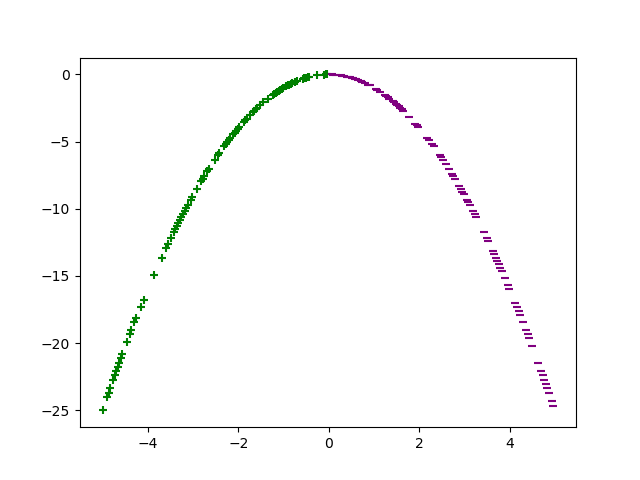

<IPython.core.display.Javascript object>


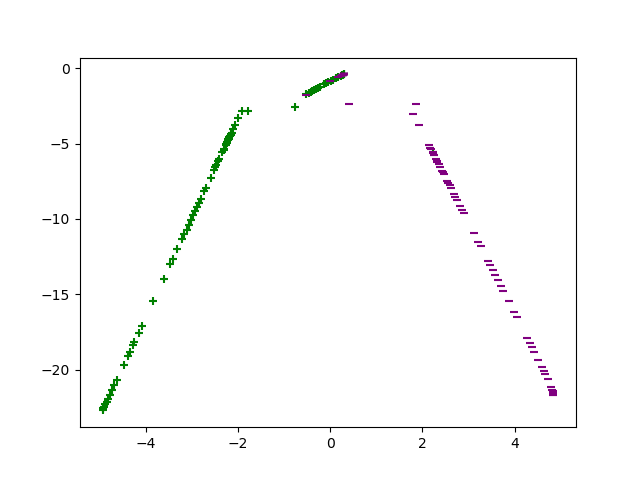

<IPython.core.display.Javascript object>


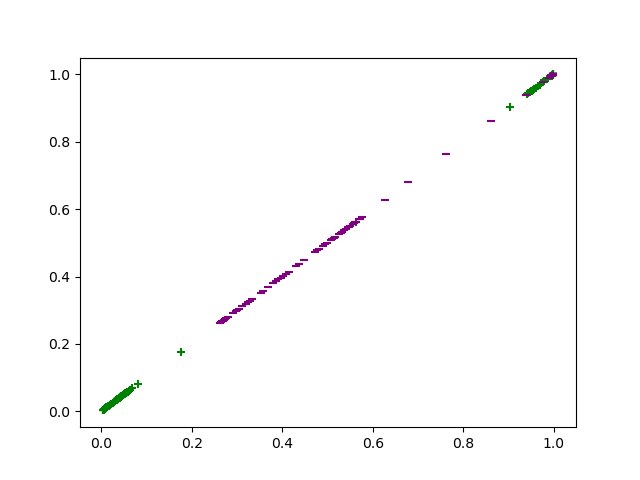

In [58]:
H, X_recons = cae.forward(X)
H = torch.cat((H, H), 1)

visualize_data(X.detach(), Y)
visualize_data(X_recons.detach(), Y)
visualize_data(H.detach(), Y)

torch.Size([180]) torch.Size([180, 2])


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


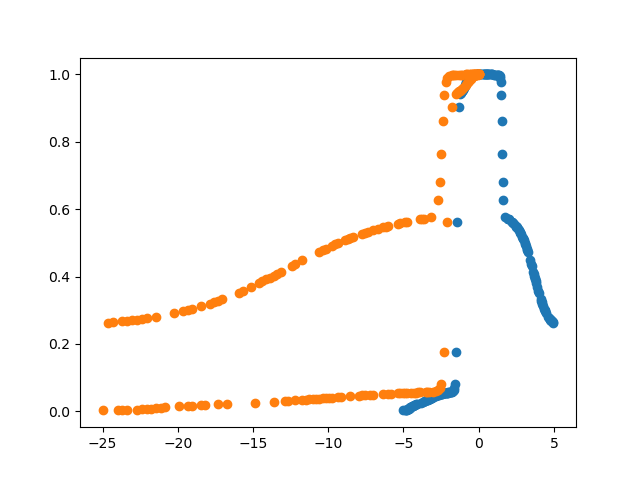

In [59]:
X1 = X[:, 0]
X2 = X[:, 1]
print(X1.size(), H.size())
fig = plt.figure()
plt.scatter(X1.detach(), H.detach()[:, 0])
plt.scatter(X2.detach(), H.detach()[:, 0])

plt.show()

<IPython.core.display.Javascript object>


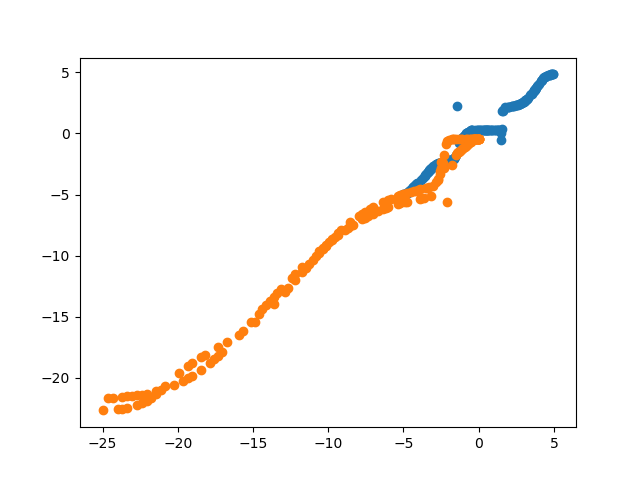

In [60]:
fig = plt.figure()
plt.scatter(X1.detach(), X_recons[:, 0].detach())
plt.scatter(X2.detach(), X_recons[:, 1].detach())
plt.show()

In [61]:
np.mean((X.detach().numpy()-X_recons.detach().numpy())**2)

0.5049415679337217

In [62]:
B_SPANS = cae.get_spans(X)
B_SPANSval = cae.get_spans(Xval)
B_SPANStest = cae.get_spans(Xtest)

In [63]:
_X, _Y = gen_custom_sin_data(50, shuff=False)

_B = cae.get_spans(_X)

print(_X)
print(_B)

tensor([[ -5.0000, -25.0000],
        [ -4.7917, -22.9601],
        [ -4.5833, -21.0069],
        [ -4.3750, -19.1406],
        [ -4.1667, -17.3611],
        [ -3.9583, -15.6684],
        [ -3.7500, -14.0625],
        [ -3.5417, -12.5434],
        [ -3.3333, -11.1111],
        [ -3.1250,  -9.7656],
        [ -2.9167,  -8.5069],
        [ -2.7083,  -7.3351],
        [ -2.5000,  -6.2500],
        [ -2.2917,  -5.2517],
        [ -2.0833,  -4.3403],
        [ -1.8750,  -3.5156],
        [ -1.6667,  -2.7778],
        [ -1.4583,  -2.1267],
        [ -1.2500,  -1.5625],
        [ -1.0417,  -1.0851],
        [ -0.8333,  -0.6944],
        [ -0.6250,  -0.3906],
        [ -0.4167,  -0.1736],
        [ -0.2083,  -0.0434],
        [  0.0000,  -0.0000],
        [  0.0000,  -0.0000],
        [  0.2083,  -0.0434],
        [  0.4167,  -0.1736],
        [  0.6250,  -0.3906],
        [  0.8333,  -0.6944],
        [  1.0417,  -1.0851],
        [  1.2500,  -1.5625],
        [  1.4583,  -2.1267],
        [ 

<IPython.core.display.Javascript object>


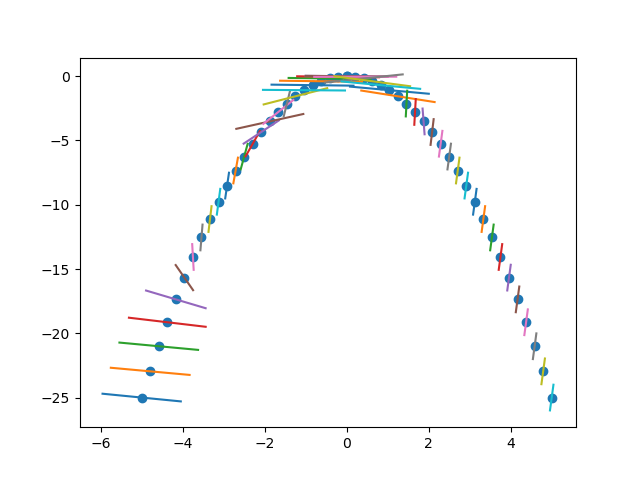

In [67]:
fig = plt.figure()
plt.scatter(_X[:, 0], _X[:, 1])
for x, b in zip(_X, np.squeeze(_B)):
    xm = x-b
    xp = x+b
    plt.plot([xm[0], xp[0]], [xm[1], xp[1]])
plt.show()

# Train

In [112]:
now = datetime.now()
PATH = "C:/Users/sagil/Desktop/nir_project/models/manifold/" + now.strftime("%d-%m-%Y_%H-%M-%S")

EPOCHS = 6
BATCH_SIZE = 24

# non-strategic classification
print("---------- training non-strategically----------")
non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)

non_strategic_model.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="non_strategic")

# strategic classification
print("---------- training strategically----------")
strategic_model_naive = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=False)

strategic_model_naive.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="strategic_naive")

# strategic classification
print("---------- training strategically----------")
strategic_model_man = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=True)

strategic_model_man.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="strategic_man")
print("done")

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix

---------- training non-strategically----------
batch 001 / 008 | loss: 0.65634 | err: 0.12500
batch 002 / 008 | loss: 0.37221 | err: 0.06250
batch 003 / 008 | loss: 0.25189 | err: 0.04167
batch 004 / 008 | loss: 0.19344 | err: 0.03125
batch 005 / 008 | loss: 0.17291 | err: 0.02500
batch 006 / 008 | loss: 0.14664 | err: 0.02083
batch 007 / 008 | loss: 0.12711 | err: 0.01786
batch 008 / 008 | loss: 0.12769 | err: 0.01562
model saved!
----- epoch 001 / 006 | time: 000 sec | loss: 0.03328 | err: 0.01667
batch 001 / 008 | loss: 0.00000 | err: 0.00000
batch 002 / 008 | loss: 0.00000 | err: 0.00000
batch 003 / 008 | loss: 0.00000 | err: 0.00000
batch 004 / 008 | loss: 0.02139 | err: 0.01042
batch 005 / 008 | loss: 0.03387 | err: 0.01667
batch 006 / 008 | loss: 0.02822 | err: 0.01389
batch 007 / 008 | loss: 0.02788 | err: 0.01190
batch 008 / 008 | loss: 0.02440 | err: 0.01042
model saved!
----- epoch 002 / 006 | time: 000 sec | loss: 0.03091 | err: 0.00000
batch 001 / 008 | loss: 0.06513 | er

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 1.22753 | err: 0.37500


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 002 / 008 | loss: 1.39120 | err: 0.47917
batch 003 / 008 | loss: 1.35847 | err: 0.50000
batch 004 / 008 | loss: 1.43034 | err: 0.52083
batch 005 / 008 | loss: 1.43080 | err: 0.52500
batch 006 / 008 | loss: 1.39932 | err: 0.52778
batch 007 / 008 | loss: 1.26963 | err: 0.48810
batch 008 / 008 | loss: 1.42618 | err: 0.51042
model saved!
----- epoch 001 / 006 | time: 037 sec | loss: 0.88409 | err: 0.35000
batch 001 / 008 | loss: 0.66928 | err: 0.25000
batch 002 / 008 | loss: 0.82125 | err: 0.37500
batch 003 / 008 | loss: 0.92268 | err: 0.40278
batch 004 / 008 | loss: 1.07128 | err: 0.45833
batch 005 / 008 | loss: 1.08654 | err: 0.46667
batch 006 / 008 | loss: 1.01820 | err: 0.45139
batch 007 / 008 | loss: 0.95637 | err: 0.42262
batch 008 / 008 | loss: 0.87629 | err: 0.39062
model saved!
----- epoch 002 / 006 | time: 031 sec | loss: 0.51267 | err: 0.26667
batch 001 / 008 | loss: 0.80231 | err: 0.41667
batch 002 / 008 | loss: 0.81171 | err: 0.39583
batch 003 / 008 | loss: 0.69222 | err

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 1.04536 | err: 0.37500
batch 002 / 008 | loss: 1.00303 | err: 0.33333


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 003 / 008 | loss: 1.17525 | err: 0.29167
batch 004 / 008 | loss: 0.97032 | err: 0.26042
batch 005 / 008 | loss: 0.83027 | err: 0.22500
batch 006 / 008 | loss: 0.78765 | err: 0.21528
batch 007 / 008 | loss: 0.72933 | err: 0.20238
batch 008 / 008 | loss: 0.70982 | err: 0.19792
model saved!
----- epoch 001 / 006 | time: 018 sec | loss: 0.46044 | err: 0.13333
batch 001 / 008 | loss: 0.54067 | err: 0.16667
batch 002 / 008 | loss: 0.83490 | err: 0.33333
batch 003 / 008 | loss: 0.69223 | err: 0.26389
batch 004 / 008 | loss: 0.72574 | err: 0.26042
batch 005 / 008 | loss: 0.66812 | err: 0.23333
batch 006 / 008 | loss: 0.63159 | err: 0.21528
batch 007 / 008 | loss: 0.73015 | err: 0.24405
batch 008 / 008 | loss: 0.75187 | err: 0.23437
----- epoch 002 / 006 | time: 023 sec | loss: 0.50638 | err: 0.13333
batch 001 / 008 | loss: 0.59958 | err: 0.16667
batch 002 / 008 | loss: 0.84555 | err: 0.22917
batch 003 / 008 | loss: 0.77023 | err: 0.20833
batch 004 / 008 | loss: 0.65653 | err: 0.17708
bat

# Test results

In [113]:
non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)
non_strategic_model.load_model(PATH + "/non_strategic/model.pt")

strategic_model_naive = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=False)
strategic_model_naive.load_model(PATH + "/strategic_naive/model.pt")

strategic_model_man = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=True)
strategic_model_man.load_model(PATH + "/strategic_man/model.pt")

# calculate results
accuracies = np.zeros(4)

# non strategic model & non strategic data
accuracies[0] = (non_strategic_model.evaluate(Xtest, B_SPANStest, Ytest))

# naive strategic model & strategic data
Xtest_opt = strategic_model_naive.optimize_X(Xtest, B_SPANStest)
test_scores = strategic_model_naive.score(Xtest_opt)
accuracies[1] = (strategic_model_naive.calc_accuracy(Ytest, test_scores))

# manifold strategic model & strategic data
Xtest_opt = strategic_model_man.optimize_X(Xtest, B_SPANStest)
test_scores = strategic_model_man.score(Xtest_opt)
accuracies[2] = (strategic_model_man.calc_accuracy(Ytest, test_scores))

# non strategic model & strategic data
Xtest_opt = non_strategic_model.optimize_X(Xtest, B_SPANStest)
accuracies[3] = (non_strategic_model.evaluate(Xtest_opt, B_SPANStest, Ytest))

pd.DataFrame(accuracies).to_csv(PATH + '/results.csv')

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix

In [114]:
print(non_strategic_model.w, non_strategic_model.b)
print(strategic_model_naive.w, strategic_model_naive.b)
print(strategic_model_man.w, strategic_model_man.b)

Parameter containing:
tensor([-4.3471, -0.2159], requires_grad=True) Parameter containing:
tensor([0.0934], requires_grad=True)
Parameter containing:
tensor([-0.4086, -0.0696], requires_grad=True) Parameter containing:
tensor([-2.5914], requires_grad=True)
Parameter containing:
tensor([-0.7706, -0.2380], requires_grad=True) Parameter containing:
tensor([-3.0668], requires_grad=True)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
xtmp = _X[28:29]
btmp = _B[28:29]

_Xtest_opt = non_strategic_model.optimize_X(xtmp, btmp)
print(xtmp)
print(btmp)
print(_Xtest_opt)

tensor([[ 0.2500, -0.7344]])
tensor([[[-1.0000],
         [-0.0040]]])
tensor([[ 0.2469, -0.7344]])


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

<IPython.core.display.Javascript object>


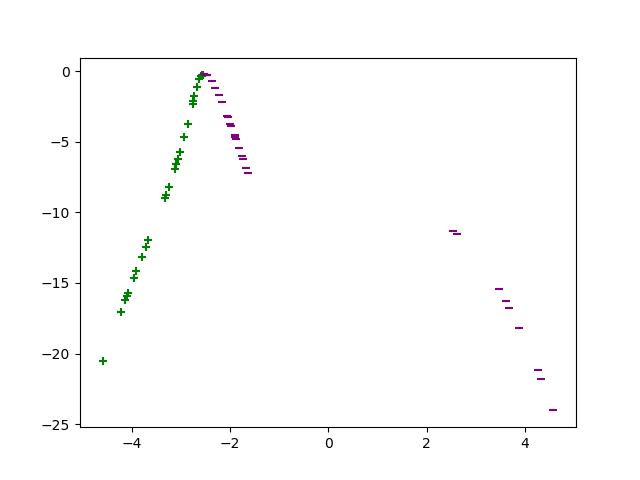

In [110]:
ccp = CCP(x_dim, h_dim, funcs)
X_opt = ccp.optimize_X(Xtest, strategic_model_naive.w, strategic_model_naive.b, B_SPANStest, EVAL_SLOPE)
visualize_data(X_opt, Ytest)


In [115]:
Xtest_opt_non_strategic = non_strategic_model.optimize_X(Xtest, B_SPANStest)
Xtest_opt_naive = strategic_model_naive.optimize_X(Xtest, B_SPANStest)
Xtest_opt_man = strategic_model_man.optimize_X(Xtest, B_SPANStest)

<IPython.core.display.Javascript object>


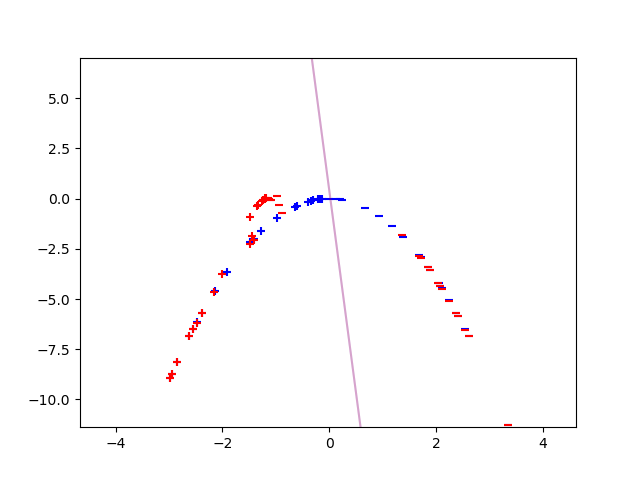

<IPython.core.display.Javascript object>


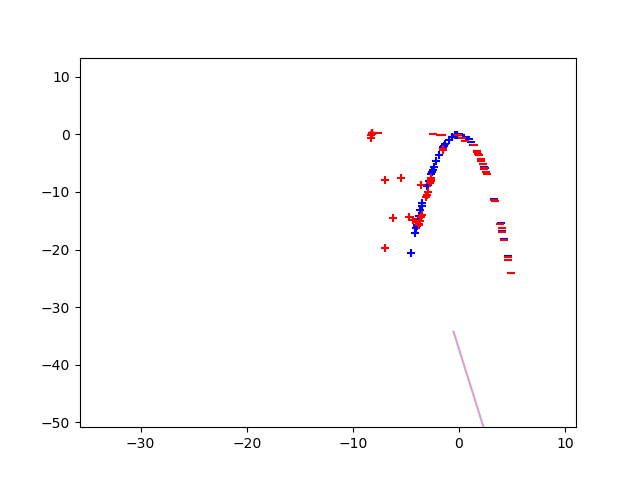

<IPython.core.display.Javascript object>


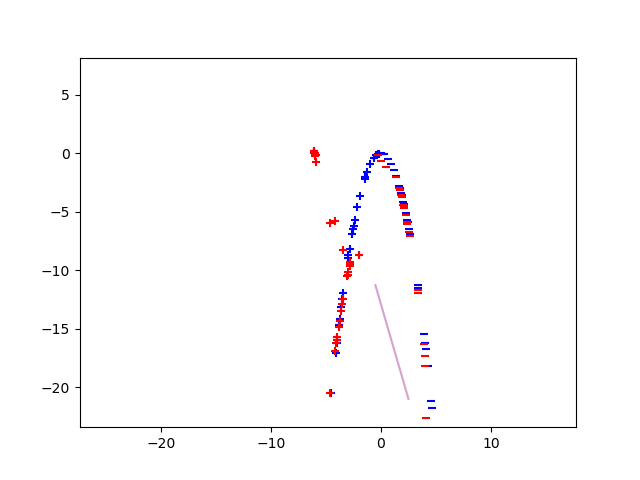

In [116]:
visualize_strategic_data(Xtest, Xtest_opt_non_strategic, Ytest, non_strategic_model.w, non_strategic_model.b, non_strategic_model.w, non_strategic_model.b)
visualize_strategic_data(Xtest, Xtest_opt_naive, Ytest, strategic_model_naive.w, strategic_model_naive.b, strategic_model_naive.w, strategic_model_naive.b)
visualize_strategic_data(Xtest, Xtest_opt_man, Ytest, strategic_model_man.w, strategic_model_man.b, strategic_model_man.w, strategic_model_man.b)

Parameter containing:
tensor([-0.0683], requires_grad=True)
Parameter containing:
tensor([-0.2900], requires_grad=True)
Parameter containing:
tensor([-0.2414], requires_grad=True)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


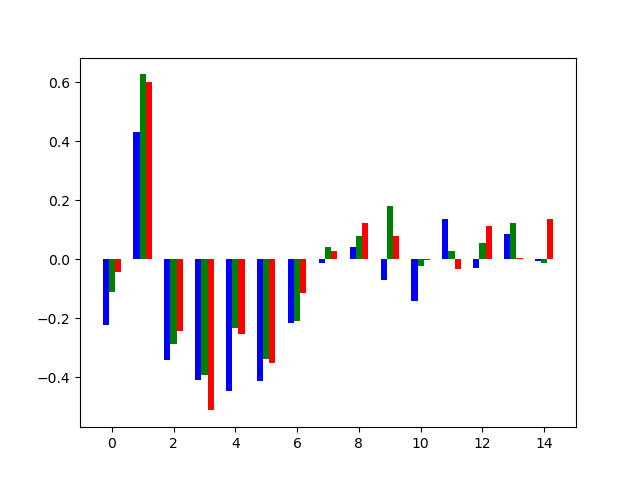

In [240]:
non_strategic_model.normalize_weights()
strategic_model_naive.normalize_weights()
strategic_model_man.normalize_weights()


print(non_strategic_model.b)
print(strategic_model_naive.b)
print(strategic_model_man.b)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(torch.arange(15)-0.2, non_strategic_model.w.detach(), width=0.2, color='b', align='center')
ax.bar(torch.arange(15), strategic_model_naive.w.detach(), width=0.2, color='g', align='center')
ax.bar(torch.arange(15)+0.2, strategic_model_man.w.detach(), width=0.2, color='r', align='center')
plt.show()